# Intro

[UrbanSound8k](https://www.kaggle.com/datasets/chrisfilo/urbansound8k) is a widely used dataset in the field of sound classification and analysis. It consists of 8732 labeled sound excerpts from field recordings in various urban environments. The dataset is organized into 10 different classes, representing different sound categories such as air conditioner, car horn, children playing, dog bark, drilling, engine idling, gun shot, jackhammer, siren, and street music.

In this notebook, we try to train a model to classify the sound clips into the 10 different classes. We will use the [librosa](https://librosa.org/doc/latest/index.html) library to extract features from the sound clips and then use Keras to train a CNN model.

### Methodology

1. **Feature extraction**: There are 2 ways to extract features from audio files.
    - Using the [Mel-frequency cepstral coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) or MFCCs.
    - Making the spectrogram of the audio file and extracting features from it as an image.
    
    This notebook uses the second method. The class labels have been converted to categorical data for classification.
1. **Model**: A CNN model is used to classify the audio files. 
1. **Evaluation**: The model is evaluated using the accuracy score.

# Importing Necessary Libraries

In [162]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras import models
from keras import layers
from keras import utils
from keras import optimizers

# Project Specific Libraries
import librosa
import librosa.display

pd.plotting.register_matplotlib_converters()

# Analysing Data Type and Format

#### Analysing CSV Data

In [67]:
dataset_folder = "./dataset"
metadata_file = f"{dataset_folder}/UrbanSound8K.csv"

# We will extract classes from this metadata.
df = pd.read_csv(metadata_file)
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


### Columns

- `slice_file_name`: The name of the audio file in the following format: `[fsID]-[classID]-[occurrenceID]-[sliceID].wav`, where:
    - `fsID`: the Freesound ID of the recording from which this excerpt (slice) is taken
    - `classID`: a numeric identifier of the sound class (see description of classID below for further details)
    - `occurrenceID`: a numeric identifier to distinguish different occurrences of the sound within the original recording
    - `sliceID`: a numeric identifier to distinguish different slices taken from the same occurrence

* `fsID`: The Freesound ID of the recording from which this excerpt (slice) is taken
* `start`: The start time of the slice in the original Freesound recording
* `end`: The end time of slice in the original Freesound recording
* `salience`: A (subjective) salience rating of the sound. `1 = foreground`, `2 = background`
* `fold`: The fold (folder) number (1-10) to which this file has been allocated
* `class`: The class or category name
* `classID`: A numeric identifier of the sound class
    Possible values of `class` and their `classID` are given below:
    
    | **Class**        | **ID** |
    | ---------------- | :----: |
    | air_conditioner  |    0   |
    | car_horn         |    1   |
    | children_playing |    2   |
    | dog_bark         |    3   |
    | drilling         |    4   |
    | engine_idling    |    5   |
    | gun_shot         |    6   |
    | jackhammer       |    7   |
    | siren            |    8   |
    | street_music     |    9   |



#### Using Librosa to analyse random sound sample - SPECTOGRAM

In [68]:
def analyze_audio(path: str, title: str):
    """
    Function to analyze audio file. It will plot the spectrogram using librosa.

    :param path: Path to audio file.
    :param title: Title of the plot.

    :return: None
    """
    data, _ = librosa.load(path)

    plt.figure(figsize=(20, 10))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis="linear")
    plt.colorbar(format="%+2.0f dB")

    if title is None:
        title = "Linear Frequency Power Spectrogram"

    plt.title(title)

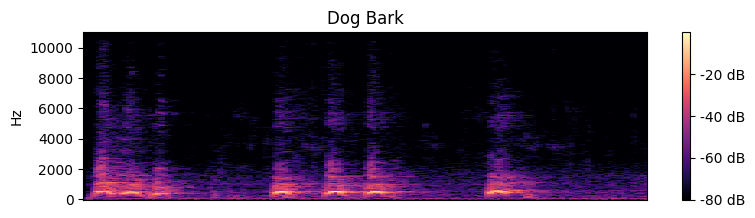

In [69]:
analyze_audio(f"{dataset_folder}/fold1/7383-3-0-0.wav", "Dog Bark")

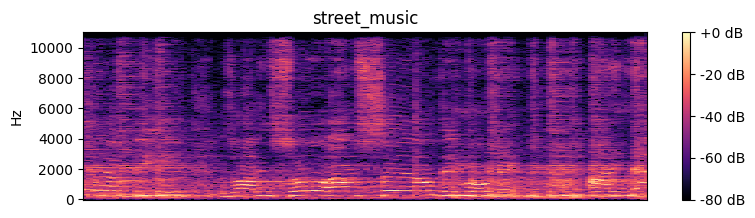

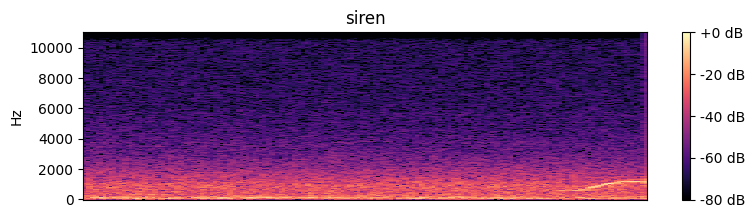

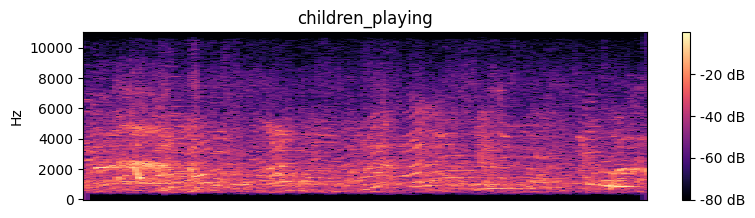

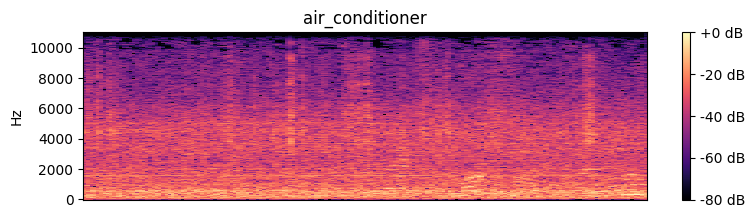

In [70]:
# Visualising the difference in spectograms for various audio inputs. 
# We take 4 random audio files from the dataset and plot their spectograms.
random_samples = df.sample(4)

for _, sample in random_samples.iterrows():
    path = f"{dataset_folder}/fold{sample['fold']}/{sample['slice_file_name']}"
    analyze_audio(path, sample["class"])

# Feature Extraction and Database Building

## Methodology

1. Librosa's `mel_spectogram` method was used to extract the spectogram data as a numpy array.
1. A 75-25 split was performed after reshaping and cleaning the data.
1. Classes (Y) have been converted to Categorically Encoded Data using `keras.utils`.

In [71]:
# Creating a helper function to return the Mel spectogram data for a given audio file.
def get_spectrogram(path: str):
    """
    Function to return the spectogram data for a given audio file.

    :param path: Path to audio file.

    :return: Spectogram data.
    """
    data, sample_rate = librosa.load(path)
    mels = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    
    return mels


In [72]:
# Example usage for one of the audio files.
random = df.sample(1).iloc[0]
mel = get_spectrogram(f"{dataset_folder}/fold{random['fold']}/{random['slice_file_name']}")
mel.shape

(128,)

In [83]:
from tqdm.notebook import tqdm

def run():
    feature = []
    label = []

    # Function to load files and extract features
    for _, sample in tqdm(df.iterrows(), total=len(df)):
        path = f"{dataset_folder}/fold{sample['fold']}/{sample['slice_file_name']}"

        mels = get_spectrogram(path)

        feature.append(mels)
        label.append(sample["classID"])

    return np.array(feature), np.array(label)

>
> **⚠️ Warning**
>
> Running the below loop may take upto 45 minutes depending on your system since it has to extract spectogram data for around 8.7k audio files.
>

In [84]:
# Warning: This might take a long time to run.
features, labels = run()

  0%|          | 0/8732 [00:00<?, ?it/s]

/Users/kretaceous/misc/urban/lib/python3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/Users/kretaceous/misc/urban/lib/python3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/Users/kretaceous/misc/urban/lib/python3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [115]:
print(features.shape, labels.shape)

X = features.copy()
Y = utils.to_categorical(labels)

# Final shape of data
print(X.shape, Y.shape)

(8732, 128) (8732,)
(8732, 128) (8732, 10)


In [170]:
# Splitting the data into train and test sets. 
# We will use 25% of the data for testing and the rest for training.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1, stratify=labels, test_size=0.25)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(6549, 128) (2183, 128) (6549, 10) (2183, 10)


In [171]:
# We need to reshape the data to fit the input shape of the model.
# We will use the input shape as (16, 8, 1).

input_dim = (16, 8, 1)

X_train = X_train.reshape(len(X_train), *input_dim)
X_test = X_test.reshape(len(X_test), *input_dim)

print(X_train.shape, X_test.shape)

(6549, 16, 8, 1) (2183, 16, 8, 1)


# Creating Keras Model and Testing

The model uses:
- 2 CNN layers with 32 and 64 units respectively along with `relu` activation.
- A dense layer with 128 units and `relu` activation. 
- A dropout Layer with 0.2 drop probability.
- Another dense layer with 10 units and `softmax` activation.
- Adam optimizer with `categorical_crossentropy` loss function with a learning rate of 0.001.

100 epochs have been used.

In [172]:
# Setup the model

# Model Definition
model = models.Sequential()

# Convolutional layers
model.add(
    layers.Conv2D(64, 3, padding="same", activation="relu", input_shape=(input_dim))
)
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, 3, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten layer to transition from convolutional to dense layers
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.1))

# Output layer
number_of_classes = 10  # 10 classes in the dataset
model.add(layers.Dense(number_of_classes, activation="softmax"))

In [178]:
from tqdm.keras import TqdmCallback

# Model Compilation and Training

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=50,
    validation_data=(X_test, Y_test),
    callbacks=[TqdmCallback(verbose=1)],
    verbose=0,
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [185]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 16, 8, 64)         640       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 8, 4, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 8, 4, 128)         73856     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 4, 2, 128)         0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 1024)              0         
                                                                 
 dense_12 (Dense)            (None, 1024)            

In [186]:
predictions = model.predict(X_test, verbose=0)
score = model.evaluate(X_test, Y_test, verbose=0)

print("Test loss:", score[0])
print("Test accuracy:", score[1])

preds = np.argmax(predictions, axis=1)
result = pd.DataFrame(preds)

model.save("results/audio_classification.keras")
result.to_csv("results/UrbanSound8kResults.csv")

print()

Test loss: 6.739051342010498
Test accuracy: 0.889601469039917

